In [81]:
from IPython import get_ipython
from IPython.display import display
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import numpy as np
from tensorflow import keras
from keras import models
from keras import layers
import time
import csv

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [82]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 特徵名稱
feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

# 第一筆訓練資料
first_data = train_data[0]
first_target = train_targets[0]

explanations = [
    "每個城鎮的犯罪率",
    "住宅用地比例",
    "非零售商業用地比例",
    "查爾斯河虛擬變數",
    "氮氧化物濃度",
    "每戶平均房間數",
    "1940年之前建造的業主自用住宅比例",
    "到波士頓五個就業中心的加權距離",
    "高速公路可達性指數",
    "每$10,000美元的財產稅率",
    "每個城鎮的師生比例",
    "1000 * (Bk - 0.63)^2，其中Bk為該地區的黑人比例",
    "低社會經濟地位人口的百分比"
]


print(f"第一筆訓練資料：")
print("="*70)

for i, (name, value, explanation) in enumerate(zip(feature_names, first_data, explanations)):
    print(f"{name} - {explanation:} : {value}")

# 顯示房價中位數對應的資料
print("="*70)
print(f"MEDV (房價中位數): {first_target * 1000:,.2f} 美元")

第一筆訓練資料：
CRIM - 每個城鎮的犯罪率 : 1.23247
ZN - 住宅用地比例 : 0.0
INDUS - 非零售商業用地比例 : 8.14
CHAS - 查爾斯河虛擬變數 : 0.0
NOX - 氮氧化物濃度 : 0.538
RM - 每戶平均房間數 : 6.142
AGE - 1940年之前建造的業主自用住宅比例 : 91.7
DIS - 到波士頓五個就業中心的加權距離 : 3.9769
RAD - 高速公路可達性指數 : 4.0
TAX - 每$10,000美元的財產稅率 : 307.0
PTRATIO - 每個城鎮的師生比例 : 21.0
B - 1000 * (Bk - 0.63)^2，其中Bk為該地區的黑人比例 : 396.9
LSTAT - 低社會經濟地位人口的百分比 : 18.72
MEDV (房價中位數): 15,200.00 美元


In [83]:
test_data.shape #測試集有102筆數據，每筆有13個特徵

(102, 13)

In [84]:
train_targets #404個對應的房價

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [85]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std
#標準化數據，使其平均值為0，標準差為1，這樣可以讓梯度下降更有效率

###比較不同神經元數###

In [86]:
#原始model
def build_model_original():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),#64個神經元 activation使用relu
        layers.Dense(64, activation="relu"),
        layers.Dense(1)#最後一層只有1個神經元，因為是回歸問題，只需要輸出一個數值
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model
#原始model+多256神經元
def build_model_256():
    model = keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model
#原始model+多1024神經元
def build_model_1024():
    model = keras.Sequential([
        layers.Dense(1024, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model

In [87]:
# 原始神經元模型
model_original = build_model_original()
start_time = time.time()
model_original.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
end_time = time.time()
training_time_original = end_time - start_time
# 訓練集評估
train_mse, train_mae, train_rmse, train_mape = model_original.evaluate(train_data, train_targets, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_original.evaluate(test_data, test_targets, verbose=0)
test_mse_original, test_mae_original, test_rmse_original, test_mape_original = test_mse, test_mae, test_rmse, test_mape
train_mse_original, train_mae_original, train_rmse_original, train_mape_original = train_mse, train_mae, train_rmse, train_mape

# 256神經元模型
model_256 = build_model_256()
start_time = time.time()
model_256.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
end_time = time.time()
training_time_256 = end_time - start_time
# 訓練集評估
train_mse, train_mae, train_rmse, train_mape = model_256.evaluate(train_data, train_targets, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_256.evaluate(test_data, test_targets, verbose=0)
test_mse_256, test_mae_256, test_rmse_256, test_mape_256 = test_mse, test_mae, test_rmse, test_mape
train_mse_256, train_mae_256, train_rmse_256, train_mape_256 = train_mse, train_mae, train_rmse, train_mape

# 1024神經元模型
model_1024 = build_model_1024()
start_time = time.time()
model_1024.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
end_time = time.time()
training_time_1024 = end_time - start_time
# 訓練集評估
train_mse, train_mae, train_rmse, train_mape = model_1024.evaluate(train_data, train_targets, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_1024.evaluate(test_data, test_targets, verbose=0)
test_mse_1024, test_mae_1024, test_rmse_1024, test_mape_1024 = test_mse, test_mae, test_rmse, test_mape
train_mse_1024, train_mae_1024, train_rmse_1024, train_mape_1024 = train_mse, train_mae, train_rmse, train_mape

In [88]:
print("模型訓練時間：")
print("-" * 70)
print(f"原始模型訓練時間: {training_time_original:.2f} 秒")
print(f"256神經元模型訓練時間: {training_time_256:.2f} 秒")
print(f"1024神經元模型訓練時間: {training_time_1024:.2f} 秒")
print("=" * 70)
print("模型效能（訓練集）：")
print("-" * 70)
print("模型\t\tMAE\t\tRMSE\t\tMAPE")
print("-" * 70)
print(f"原始模型\t{train_mae_original:.3f}\t\t{train_rmse_original:.3f}\t\t{train_mape_original:.3f}")
print(f"256神經元模型\t{train_mae_256:.3f}\t\t{train_rmse_256:.3f}\t\t{train_mape_256:.3f}")
print(f"1024神經元模型\t{train_mae_1024:.3f}\t\t{train_rmse_1024:.3f}\t\t{train_mape_1024:.3f}")
print("=" * 70)
print("模型效能（測試集）：")
print("-" * 70)
print("模型\t\tMAE\t\tRMSE\t\tMAPE")
print("-" * 70)
print(f"原始模型\t{test_mae_original:.3f}\t\t{test_rmse_original:.3f}\t\t{test_mape_original:.3f}")
print(f"256神經元模型\t{test_mae_256:.3f}\t\t{test_rmse_256:.3f}\t\t{test_mape_256:.3f}")
print(f"1024神經元模型\t{test_mae_1024:.3f}\t\t{test_rmse_1024:.3f}\t\t{test_mape_1024:.3f}")
print("=" * 70)

模型訓練時間：
----------------------------------------------------------------------
原始模型訓練時間: 16.59 秒
256神經元模型訓練時間: 17.42 秒
1024神經元模型訓練時間: 69.74 秒
模型效能（訓練集）：
----------------------------------------------------------------------
模型		MAE		RMSE		MAPE
----------------------------------------------------------------------
原始模型	1.595		2.237		8.010
256神經元模型	1.129		1.561		5.854
1024神經元模型	1.250		1.653		6.279
模型效能（測試集）：
----------------------------------------------------------------------
模型		MAE		RMSE		MAPE
----------------------------------------------------------------------
原始模型	2.624		4.193		13.024
256神經元模型	2.389		3.416		11.910
1024神經元模型	2.706		3.706		14.064


###比較不同深度###

In [89]:
#原始model+5層數
def build_model_layers5():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model

#原始model+7層數
def build_model_layers7():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model

In [90]:
# 5層神經元模型
model_layers5 = build_model_layers5()
start_time = time.time()
model_layers5.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
end_time = time.time()
training_time_layers5 = end_time - start_time
# 訓練集評估
train_mse, train_mae, train_rmse, train_mape = model_layers5.evaluate(train_data, train_targets, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_layers5.evaluate(test_data, test_targets, verbose=0)
test_mse_layers5, test_mae_layers5, test_rmse_layers5, test_mape_layers5 = test_mse, test_mae, test_rmse, test_mape
train_mse_layers5, train_mae_layers5, train_rmse_layers5, train_mape_layers5 = train_mse, train_mae, train_rmse, train_mape

# 7層神經元模型
model_layers7 = build_model_layers7()
start_time = time.time()
model_layers7.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
end_time = time.time()
training_time_layers7 = end_time - start_time
# 訓練集評估
train_mse, train_mae, train_rmse, train_mape = model_layers7.evaluate(train_data, train_targets, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_layers7.evaluate(test_data, test_targets, verbose=0)
test_mse_layers7, test_mae_layers7, test_rmse_layers7, test_mape_layers7 = test_mse, test_mae, test_rmse, test_mape
train_mse_layers7, train_mae_layers7, train_rmse_layers7, train_mape_layers7 = train_mse, train_mae, train_rmse, train_mape

In [91]:
print("模型訓練時間：")
print("-" * 70)
print(f"5層模型訓練時間: {training_time_layers5:.2f} 秒")
print(f"7層模型訓練時間: {training_time_layers7:.2f} 秒")
print("=" * 70)
print("模型效能（訓練集）：")
print("-" * 70)
print("模型\t\tMAE\t\tRMSE\t\tMAPE")
print("-" * 70)
print(f"原始模型\t{train_mae_original:.3f}\t\t{train_rmse_original:.3f}\t\t{train_mape_original:.3f}")
print(f"layers5模型\t{train_mae_layers5:.3f}\t\t{train_rmse_layers5:.3f}\t\t{train_mape_layers5:.3f}")
print(f"layers7模型\t{train_mae_layers7:.3f}\t\t{train_rmse_layers7:.3f}\t\t{train_mape_layers7:.3f}")
print("=" * 70)
print("模型效能（測試集）：")
print("-" * 70)
print("模型\t\tMAE\t\tRMSE\t\tMAPE")
print("-" * 70)
print(f"原始模型\t{test_mae_original:.3f}\t\t{test_rmse_original:.3f}\t\t{test_mape_original:.3f}")
print(f"layers5模型\t{test_mae_layers5:.3f}\t\t{test_rmse_layers5:.3f}\t\t{test_mape_layers5:.3f}")
print(f"layers7模型\t{test_mae_layers7:.3f}\t\t{test_rmse_layers7:.3f}\t\t{test_mape_layers7:.3f}")
print("=" * 70)

模型訓練時間：
----------------------------------------------------------------------
5層模型訓練時間: 17.60 秒
7層模型訓練時間: 20.98 秒
模型效能（訓練集）：
----------------------------------------------------------------------
模型		MAE		RMSE		MAPE
----------------------------------------------------------------------
原始模型	1.595		2.237		8.010
layers5模型	0.962		1.220		5.053
layers7模型	1.061		1.393		4.902
模型效能（測試集）：
----------------------------------------------------------------------
模型		MAE		RMSE		MAPE
----------------------------------------------------------------------
原始模型	2.624		4.193		13.024
layers5模型	2.314		3.637		12.756
layers7模型	2.427		3.669		12.027


###不同激活函數比較###

In [92]:
#原始model+改sigmoid
def build_model_sigmoid():
    model = keras.Sequential([
        layers.Dense(64, activation="sigmoid"),
        layers.Dense(64, activation="sigmoid"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model
#原始model+改softplus
def build_model_softplus():
    model = keras.Sequential([
        layers.Dense(64, activation="softplus"),
        layers.Dense(64, activation="softplus"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model

In [93]:
# sigmoid模型
model_sigmoid = build_model_sigmoid()
start_time = time.time()
model_sigmoid.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
end_time = time.time()
training_time_sigmoid = end_time - start_time
# 訓練集評估
train_mse, train_mae, train_rmse, train_mape = model_sigmoid.evaluate(train_data, train_targets, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_sigmoid.evaluate(test_data, test_targets, verbose=0)
test_mse_sigmoid, test_mae_sigmoid, test_rmse_sigmoid, test_mape_sigmoid = test_mse, test_mae, test_rmse, test_mape
train_mse_sigmoid, train_mae_sigmoid, train_rmse_sigmoid, train_mape_sigmoid = train_mse, train_mae, train_rmse, train_mape

# softplus模型
model_softplus = build_model_softplus()
start_time = time.time()
model_softplus.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
end_time = time.time()
training_time_softplus = end_time - start_time
# 訓練集評估
train_mse, train_mae, train_rmse, train_mape = model_softplus.evaluate(train_data, train_targets, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_softplus.evaluate(test_data, test_targets, verbose=0)
test_mse_softplus, test_mae_softplus, test_rmse_softplus, test_mape_softplus = test_mse, test_mae, test_rmse, test_mape
train_mse_softplus, train_mae_softplus, train_rmse_softplus, train_mape_softplus = train_mse, train_mae, train_rmse, train_mape


In [94]:
print("模型訓練時間：")
print("-" * 70)
print(f"sigmoid模型訓練時間: {training_time_sigmoid:.2f} 秒")
print(f"softplus模型訓練時間: {training_time_softplus:.2f} 秒")
print("=" * 70)
print("模型效能（訓練集）：")
print("-" * 70)
print("模型\t\tMAE\t\tRMSE\t\tMAPE")
print("-" * 70)
print(f"原始模型\t{train_mae_original:.3f}\t\t{train_rmse_original:.3f}\t\t{train_mape_original:.3f}")
print(f"sigmoid模型\t{train_mae_sigmoid:.3f}\t\t{train_rmse_sigmoid:.3f}\t\t{train_mape_sigmoid:.3f}")
print(f"softplus模型\t{train_mae_softplus:.3f}\t\t{train_rmse_softplus:.3f}\t\t{train_mape_softplus:.3f}")
print("=" * 70)
print("模型效能（測試集）：")
print("-" * 70)
print("模型\t\tMAE\t\tRMSE\t\tMAPE")
print("-" * 70)
print(f"原始模型\t{test_mae_original:.3f}\t\t{test_rmse_original:.3f}\t\t{test_mape_original:.3f}")
print(f"sigmoid模型\t{test_mae_sigmoid:.3f}\t\t{test_rmse_sigmoid:.3f}\t\t{test_mape_sigmoid:.3f}")
print(f"softplus模型\t{test_mae_softplus:.3f}\t\t{test_rmse_softplus:.3f}\t\t{test_mape_softplus:.3f}")
print("=" * 70)

模型訓練時間：
----------------------------------------------------------------------
sigmoid模型訓練時間: 17.17 秒
softplus模型訓練時間: 15.81 秒
模型效能（訓練集）：
----------------------------------------------------------------------
模型		MAE		RMSE		MAPE
----------------------------------------------------------------------
原始模型	1.595		2.237		8.010
sigmoid模型	2.607		3.811		12.088
softplus模型	2.044		2.923		10.049
模型效能（測試集）：
----------------------------------------------------------------------
模型		MAE		RMSE		MAPE
----------------------------------------------------------------------
原始模型	2.624		4.193		13.024
sigmoid模型	3.230		4.706		15.889
softplus模型	2.769		4.498		13.514


###不同epoch及batch size組合比較###

In [95]:
epochs_list = [20, 40, 60, 80, 100]
batch_sizes = [64, 128, 256, 512]

train_results = {}
results = {}  # 用於儲存結果

for epochs in epochs_list:
    for batch_size in batch_sizes:
        model = build_model_original()
        start_time = time.time()
        model.fit(train_data, train_targets, epochs=epochs, batch_size=batch_size, verbose=0)
        end_time = time.time()
        training_time = end_time - start_time

        # 驗證集（或測試集）結果
        test_mse, test_mae, test_rmse, test_mape = model.evaluate(test_data, test_targets, verbose=0)
        results[(epochs, batch_size)] = {
            'mse': test_mse,
            'mae': test_mae,
            'rmse': test_rmse,
            'mape': test_mape,
            'training_time': training_time
        }
        # 訓練集結果
        train_mse, train_mae, train_rmse, train_mape = model.evaluate(train_data, train_targets, verbose=0)
        train_results[(epochs, batch_size)] = {
            'mse': train_mse,
            'mae': train_mae,
            'rmse': train_rmse,
            'mape': train_mape,
            'training_time': training_time
        }

# 輸出結果（測試集）
print("測試集結果:")
for (epochs, batch_size), metrics in results.items():
    print(f"Epochs: {epochs}, Batch Size: {batch_size}, 訓練時間: {metrics['training_time']:.3f}")
    print(f"  MSE: {metrics['mse']:.3f}")
    print(f"  MAE: {metrics['mae']:.3f}")
    print(f"  RMSE: {metrics['rmse']:.3f}")
    print(f"  MAPE: {metrics['mape']:.3f}")

# 輸出結果(訓練集)
print("訓練集結果:")
for (epochs, batch_size), metrics in train_results.items():
    print(f"Epochs: {epochs}, Batch Size: {batch_size}, 訓練時間: {metrics['training_time']:.3f}")
    print(f"  MSE: {metrics['mse']:.3f}")
    print(f"  MAE: {metrics['mae']:.3f}")
    print(f"  RMSE: {metrics['rmse']:.3f}")
    print(f"  MAPE: {metrics['mape']:.3f}")

filepath = '/CSV/ans.csv'  # 確保路徑正確

# 寫入 CSV 檔案（包含訓練集和測試集）
with open(filepath, 'w', newline='') as csvfile:
    fieldnames = ['Epochs', 'Batch Size', 'Training Time', 'Set', 'MAE', 'RMSE', 'MAPE']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # 寫入測試集結果
    for (epochs, batch_size), metrics in results.items():
        writer.writerow({
            'Epochs': epochs,
            'Batch Size': batch_size,
            'Training Time': f"{metrics['training_time']:.3f}",
            'Set': 'Test',
            'MAE': f"{metrics['mae']:.3f}",
            'RMSE': f"{metrics['rmse']:.3f}",
            'MAPE': f"{metrics['mape']:.3f}"
        })

    # 寫入訓練集結果
    for (epochs, batch_size), metrics in train_results.items():
        writer.writerow({
            'Epochs': epochs,
            'Batch Size': batch_size,
            'Training Time': f"{metrics['training_time']:.3f}",
            'Set': 'Train',
            'MAE': f"{metrics['mae']:.3f}",
            'RMSE': f"{metrics['rmse']:.3f}",
            'MAPE': f"{metrics['mape']:.3f}"
        })

測試集結果:
Epochs: 20, Batch Size: 64, 訓練時間: 3.464
  MSE: 32.346
  MAE: 4.585
  RMSE: 5.687
  MAPE: 24.790
Epochs: 20, Batch Size: 128, 訓練時間: 4.066
  MSE: 78.356
  MAE: 7.098
  RMSE: 8.852
  MAPE: 34.756
Epochs: 20, Batch Size: 256, 訓練時間: 2.741
  MSE: 401.561
  MAE: 18.021
  RMSE: 20.039
  MAPE: 73.685
Epochs: 20, Batch Size: 512, 訓練時間: 2.825
  MSE: 539.255
  MAE: 21.448
  RMSE: 23.222
  MAPE: 91.873
Epochs: 40, Batch Size: 64, 訓練時間: 6.673
  MSE: 24.108
  MAE: 3.702
  RMSE: 4.910
  MAPE: 19.689
Epochs: 40, Batch Size: 128, 訓練時間: 4.234
  MSE: 26.790
  MAE: 4.170
  RMSE: 5.176
  MAPE: 23.280
Epochs: 40, Batch Size: 256, 訓練時間: 5.274
  MSE: 85.927
  MAE: 7.406
  RMSE: 9.270
  MAPE: 36.581
Epochs: 40, Batch Size: 512, 訓練時間: 3.872
  MSE: 309.228
  MAE: 15.388
  RMSE: 17.585
  MAPE: 62.954
Epochs: 60, Batch Size: 64, 訓練時間: 7.612
  MSE: 25.415
  MAE: 3.404
  RMSE: 5.041
  MAPE: 17.676
Epochs: 60, Batch Size: 128, 訓練時間: 5.638
  MSE: 22.765
  MAE: 3.573
  RMSE: 4.771
  MAPE: 18.992
Epochs: 60, Batch

In [96]:
# 找出 MAE、RMSE 和 MAPE 最小值對應的 epochs 和 batch_size
min_mae = float('inf')
min_rmse = float('inf')
min_mape = float('inf')

min_mae_epochs_batch = None
min_rmse_epochs_batch = None
min_mape_epochs_batch = None

for (epochs, batch_size), metrics in results.items():
    if metrics['mae'] < min_mae:
        min_mae = metrics['mae']
        min_mae_epochs_batch = (epochs, batch_size)
    if metrics['rmse'] < min_rmse:
        min_rmse = metrics['rmse']
        min_rmse_epochs_batch = (epochs, batch_size)
    if metrics['mape'] < min_mape:
        min_mape = metrics['mape']
        min_mape_epochs_batch = (epochs, batch_size)

print("\nMinimum MAE:")
print(f"  Epochs: {min_mae_epochs_batch[0]}, Batch Size: {min_mae_epochs_batch[1]}, MAE: {min_mae:.3f}")

print("\nMinimum RMSE:")
print(f"  Epochs: {min_rmse_epochs_batch[0]}, Batch Size: {min_rmse_epochs_batch[1]}, RMSE: {min_rmse:.3f}")

print("\nMinimum MAPE:")
print(f"  Epochs: {min_mape_epochs_batch[0]}, Batch Size: {min_mape_epochs_batch[1]}, MAPE: {min_mape:.3f}")


Minimum MAE:
  Epochs: 100, Batch Size: 64, MAE: 2.919

Minimum RMSE:
  Epochs: 100, Batch Size: 128, RMSE: 4.509

Minimum MAPE:
  Epochs: 100, Batch Size: 64, MAPE: 14.728


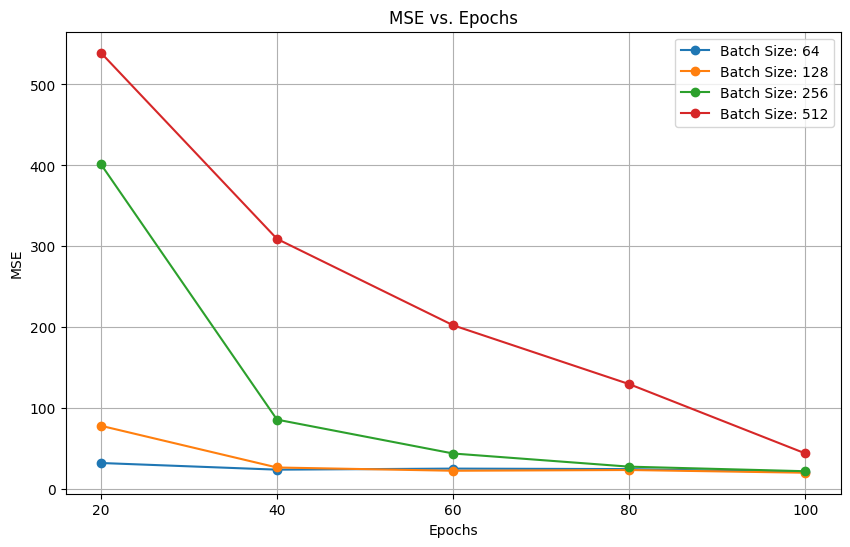

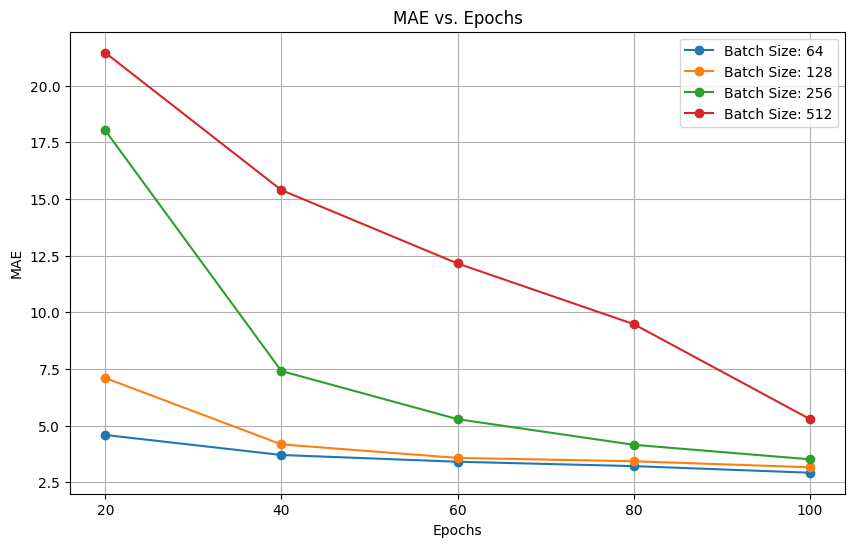

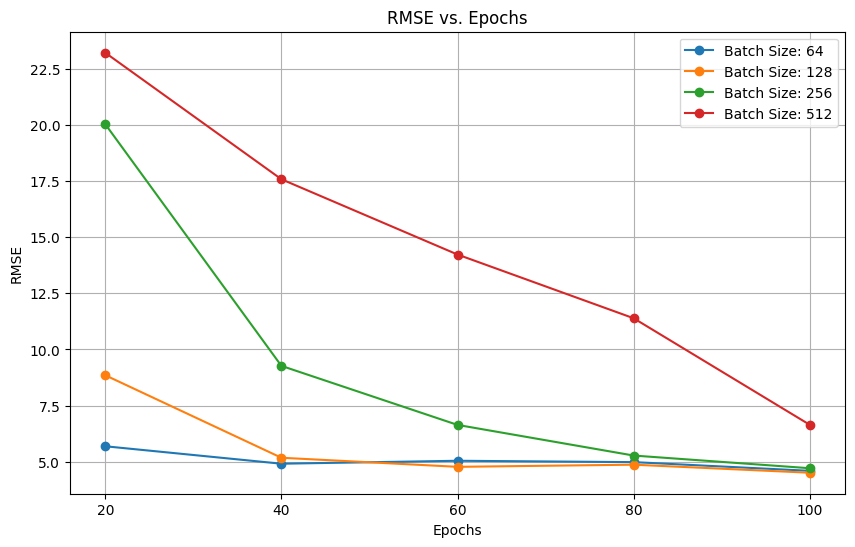

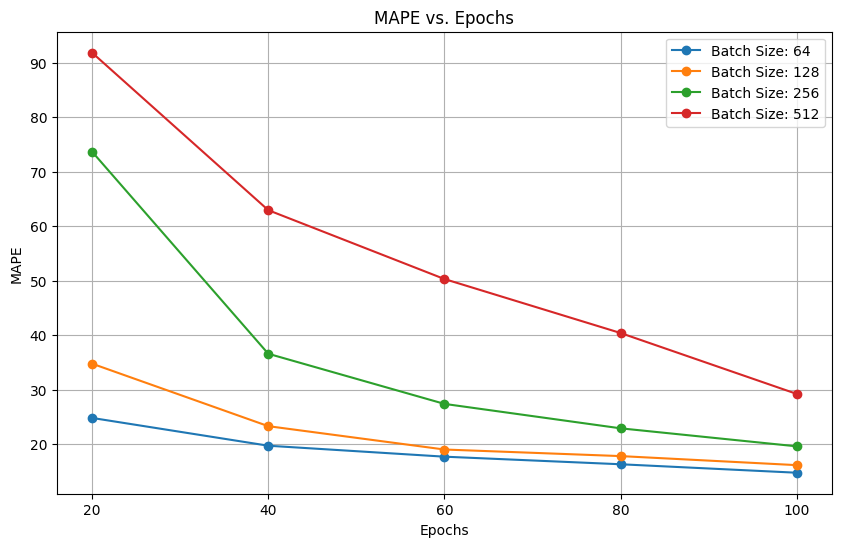

In [97]:
import matplotlib.pyplot as plt

epochs_list = [20, 40, 60, 80, 100]
batch_sizes = [64, 128, 256, 512]

metrics_by_batch_size = {
    batch_size: {
        'mse': [],
        'mae': [],
        'rmse': [],
        'mape': []
    }
    for batch_size in batch_sizes
}

for epochs in epochs_list:
    for batch_size in batch_sizes:
        metrics = results[(epochs, batch_size)]
        for metric_name in ['mse', 'mae', 'rmse', 'mape']:
            metrics_by_batch_size[batch_size][metric_name].append(metrics[metric_name])

metric_names = ['MSE', 'MAE', 'RMSE', 'MAPE']

for metric_name_lower in ['mse', 'mae', 'rmse', 'mape']:
    plt.figure(figsize=(10, 6))
    for batch_size, metrics in metrics_by_batch_size.items():
        plt.plot(epochs_list, metrics[metric_name_lower], marker='o', label=f'Batch Size: {batch_size}')

    plt.title(f'{metric_names[metric_names.index(metric_name_lower.upper())]} vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_names[metric_names.index(metric_name_lower.upper())])
    plt.xticks(epochs_list)
    plt.legend()
    plt.grid(True)
    plt.show()

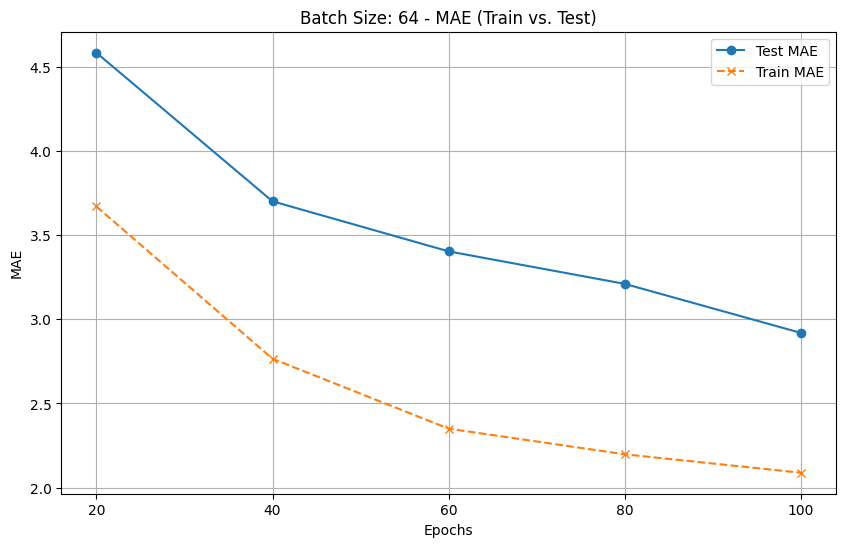

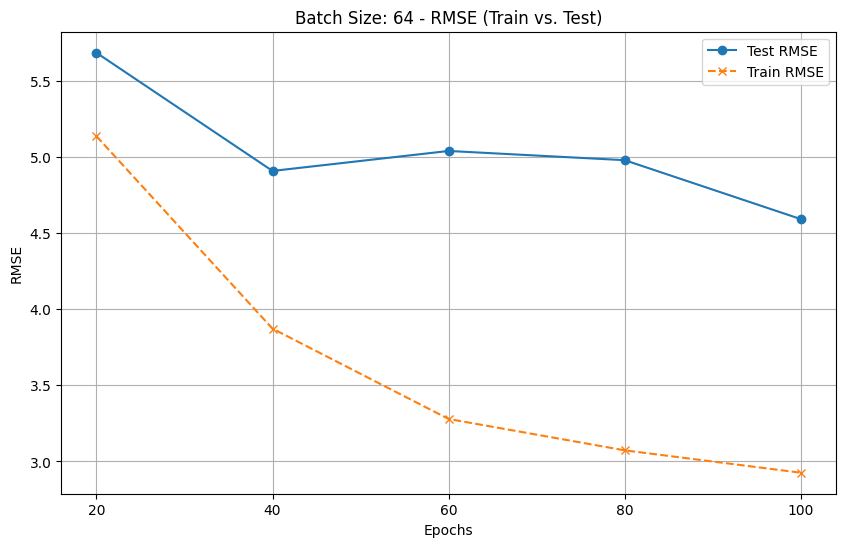

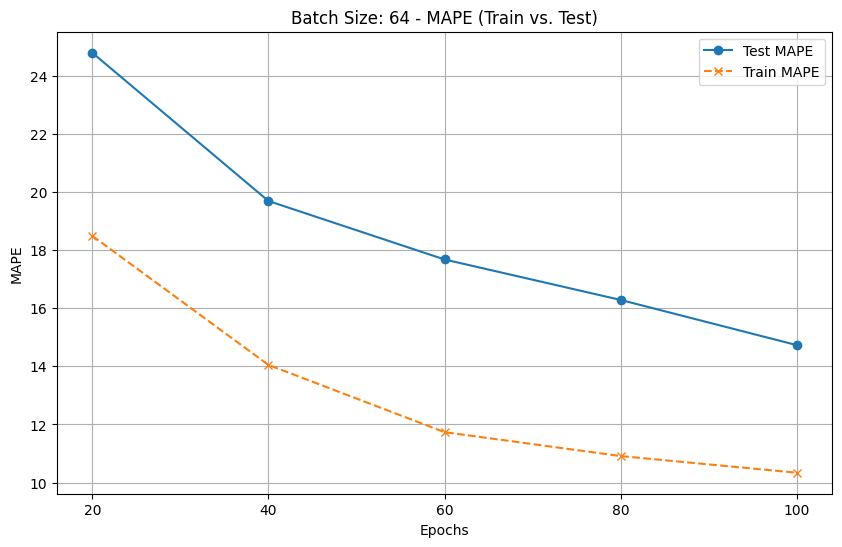

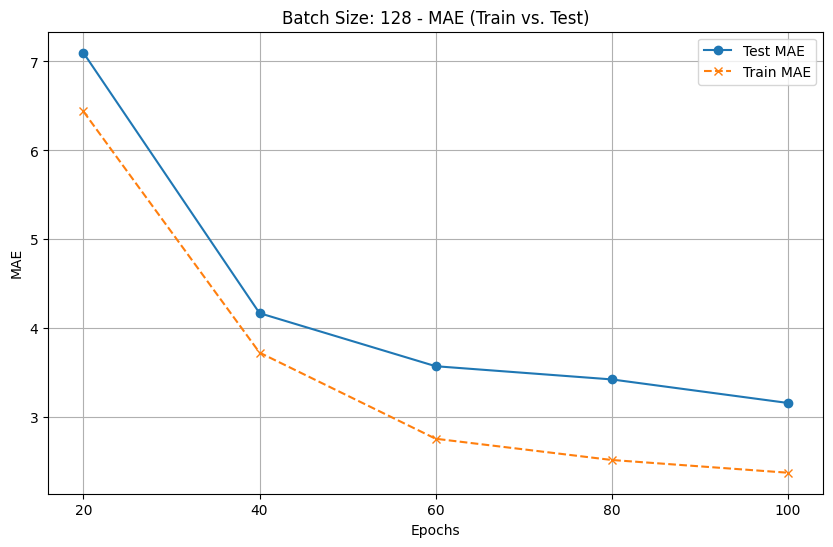

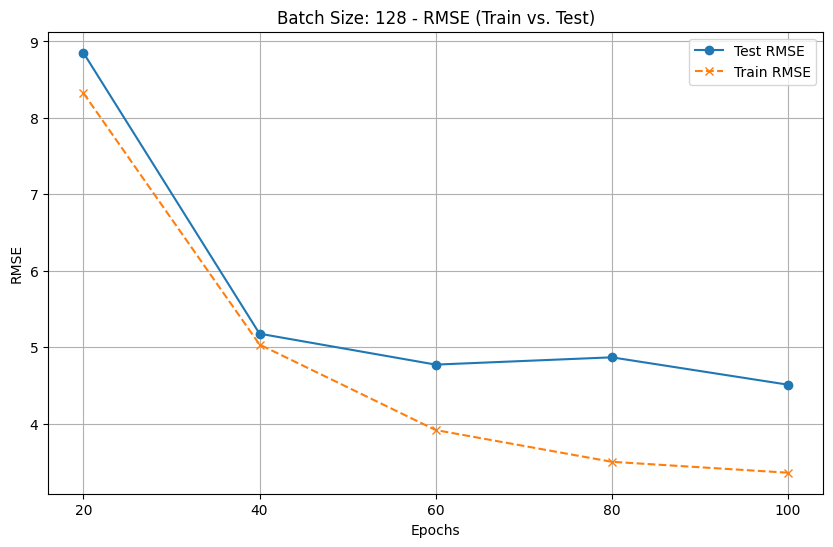

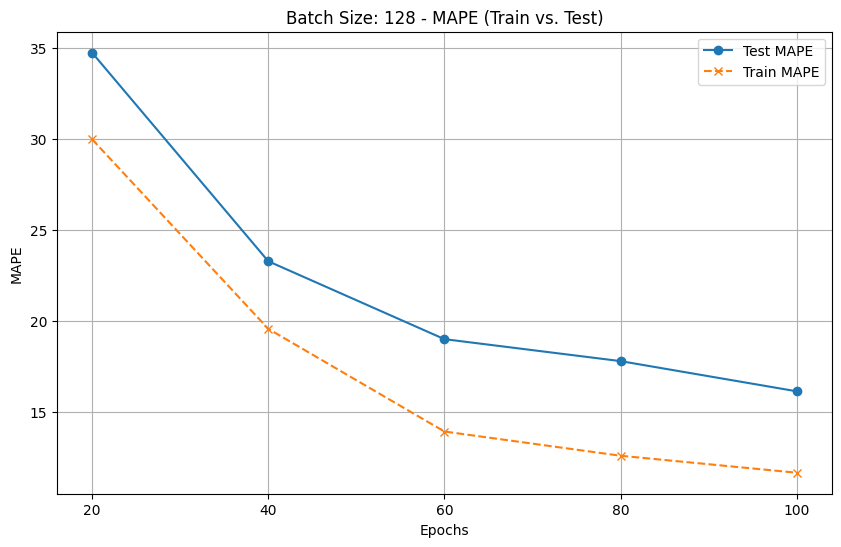

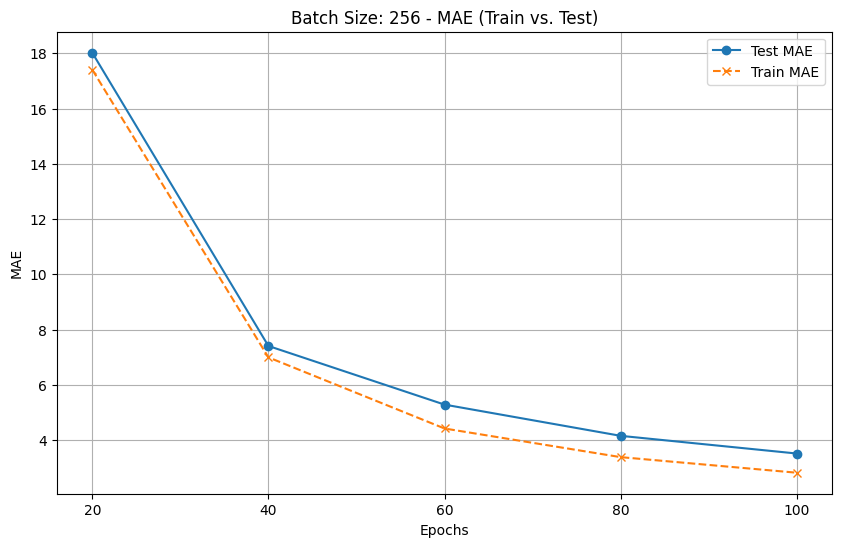

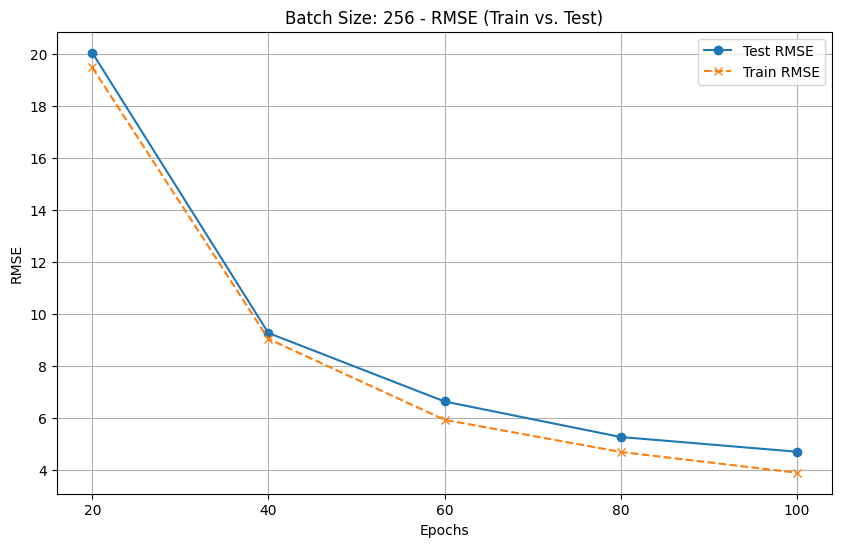

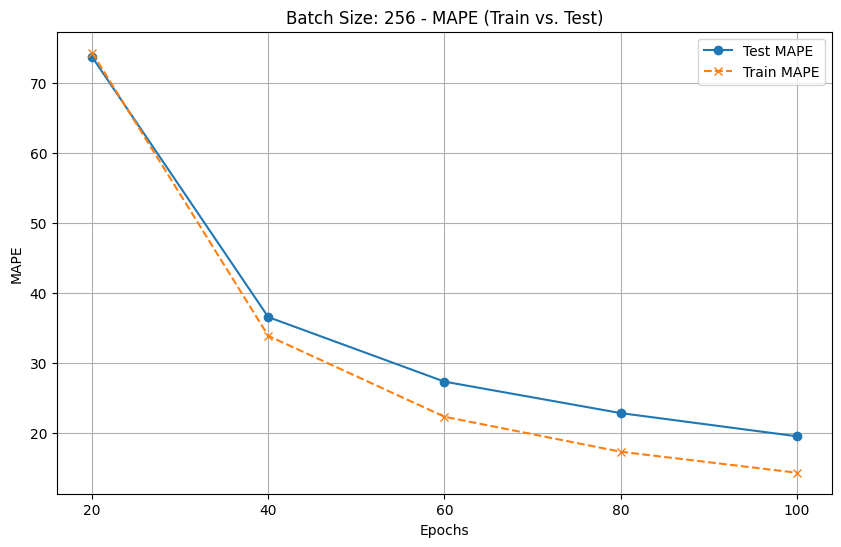

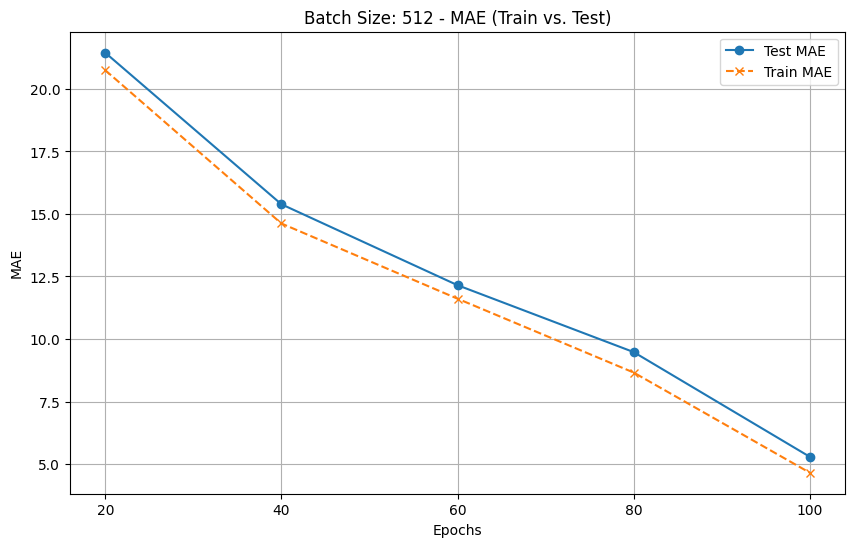

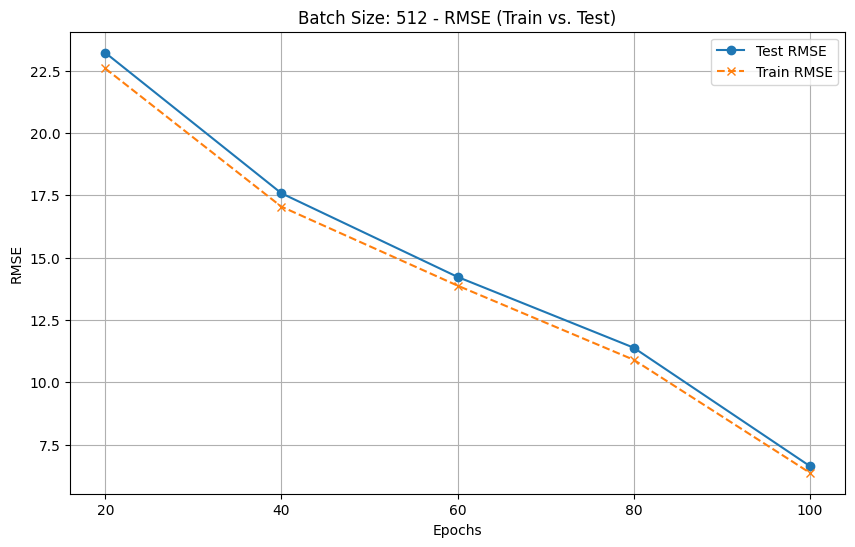

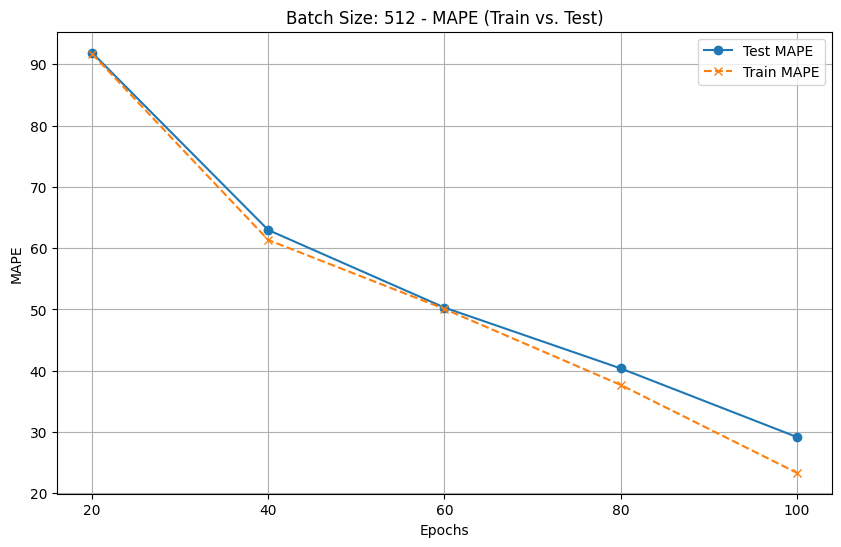

In [98]:
epochs_list = [20, 40, 60, 80, 100]
batch_sizes = [64, 128, 256, 512]
metric_names = ['MAE', 'RMSE', 'MAPE']

for batch_size in batch_sizes:
    for metric_name_lower in ['mae', 'rmse', 'mape']:
        plt.figure(figsize=(10, 6))

        test_metrics = [results[(epochs, batch_size)][metric_name_lower] for epochs in epochs_list]
        train_metrics = [train_results[(epochs, batch_size)][metric_name_lower] for epochs in epochs_list]

        plt.plot(epochs_list, test_metrics, marker='o', label=f'Test {metric_name_lower.upper()}')
        plt.plot(epochs_list, train_metrics, marker='x', linestyle='--', label=f'Train {metric_name_lower.upper()}')

        plt.title(f'Batch Size: {batch_size} - {metric_name_lower.upper()} (Train vs. Test)')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name_lower.upper())
        plt.xticks(epochs_list)
        plt.legend()
        plt.grid(True)
        plt.show()

In [99]:
predictions = model_original.predict(test_data)
predictions[0]
print(f"Actual Price: {test_targets[0]}, Predicted Price: {predictions[0][0]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual Price: 7.2, Predicted Price: 8.208298683166504


In [100]:
#迴歸問題的數值預測分別使用
#MAE、RMSE 與 MAPE 指標。
#分析淺層神經網路及深度神經網路對訓練資料集及測試資料集之預測績效的影響(課程投
'''
1.分析不同的隱藏層數量及節點數量之影響
2.分析隱藏層的激活函數使用 Sigmoid、Softplus 或 ReLU，對訓練資料集及測試資料集之預測績效的影響
3.分析設定不同的 batch size 及 epoch，對訓練模型所需之訓練時間以及模型預測績效之影響

'''

'\n1.分析不同的隱藏層數量及節點數量之影響\n2.分析隱藏層的激活函數使用 Sigmoid、Softplus 或 ReLU，對訓練資料集及測試資料集之預測績效的影響\n3.分析設定不同的 batch size 及 epoch，對訓練模型所需之訓練時間以及模型預測績效之影響\n\n'